# NBA Game Prediction: Neural Net
Written by Nicholas Cannon 22241579

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 5.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay, precision_recall_curve,
    PrecisionRecallDisplay
)

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

%matplotlib inline

DATA_DIR = os.path.join(os.getcwd(), 'drive', 'My Drive', 'teams')
STATE = 42
TEAM_IDS = os.listdir(DATA_DIR)
NON_FEATURE_COLS = ['GAME_ID', 'DATE', 'SEASON', 'TEAM', 'OPPONENT']
TEST_SIZE = 0.2

random.seed(STATE)
np.random.seed(STATE)
tf.random.set_seed(STATE)
os.environ['PYTHONHASHSEED'] = str(STATE)

## Global Functions

In [14]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    FROM: https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def run_metrics(y_pred, y_true, y_score):
    """Display Standard graphs and metrics for model evaluation"""
    fig, ax = plt.subplots(1, 3, figsize=(10, 8), constrained_layout=True)
    
    # CF Matrix
    for i in [0, 1]:        
        cf_data = confusion_matrix(y_true[i], y_pred[i], normalize='true') * 100
        im = ax[i].imshow(cf_data, cmap=plt.cm.Blues) 
        ax[i].set_xticks(np.arange(cf_data.shape[1]))
        ax[i].set_yticks(np.arange(cf_data.shape[0]))
        ax[i].set_xticklabels(['Home Lose', 'Home Win'])
        ax[i].set_yticklabels(['Home Lose', 'Home Win'], rotation=90, va='center')
        ax[i].set_title('Adv.' if i == 0 else 'Trad.')
        annotate_heatmap(im, valfmt="{x:.2f} %")

    # ROC Curve
    fpr_1, tpr_1, _ = roc_curve(y_true[0], y_score[0])
    auc_1 = auc(fpr_1, tpr_1)
    fpr_2, tpr_2, _ = roc_curve(y_true[1], y_score[1])
    auc_2 = auc(fpr_2, tpr_2)
    
    ax[2].set_xlim((0, 1))
    ax[2].set_ylim((0, 1))
    ax[2].set_aspect('equal', 'box')
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    
    ax[2].plot(fpr_1, tpr_1, label='Adv. (AUC={:.2f})'.format(auc_1))
    ax[2].plot(fpr_2, tpr_2, label='Trad. (AUC={:.2f})'.format(auc_2))
    ax[2].legend(loc='lower right')
    
    plt.show()
    return fig


def preprocess_team(team_id, drop_adv=False, season_avg=False, window=5, drop_percentages=False, 
                    split_data=True, test_size=0.2):
    """Preprocess the given teams data set with configurable options"""
    df = pd.read_csv(os.path.join(DATA_DIR, team_id))

    # shift label up 1 game
    df['WON'] = df['WON'].shift(periods=-1)
    df.dropna(inplace=True)

    # get a copy of the columns not run through averaging
    non_avgs = df[[*NON_FEATURE_COLS, 'HOME']].copy()

    # separate features and labels (and drop non feature cols)
    X = df.drop([*NON_FEATURE_COLS, 'WON', 'HOME'], axis=1)
    y = df['WON']
    
    # drop derived cols
    if drop_percentages:
        X = X.drop(['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'RBC'], axis=1)
    else:
        X = X.drop(['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'ORBC', 'DRBC',], axis=1)

    # drop the advanced stats
    if drop_adv:
        X = X.drop(['TM_TOV_PCT', 'OFF_RATING', 'DEF_RATING', 
                    'TS_PCT', 'PACE', 'PTS_OFF_TO', 'PTS_2ND_CHANCE',
                    'PTS_FB', 'PTS_PAINT', 'DIST', 'ORBC', 'DRBC', 'RBC', 'TCHS',
                    'PASS', 'CFGM', 'CFGA', 'UFGM', 'UFGA'], axis=1, errors='ignore')
    else:
        # drop the traditional stats
        X = X.drop(['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 
                    'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                    'TO', 'PF', 'PTS', 'PLUS_MINUS',
        ], axis=1, errors='ignore')

    # Run averaging and add the non_avg cols after
    if season_avg:
        X = X.expanding().mean()
        X = pd.concat([non_avgs, X], axis=1)
    else:
        X = X.rolling(window).mean()
        X = pd.concat([non_avgs, X], axis=1)

        X.dropna(inplace=True) # drop first few games
        y = y[window-1:]
    
    if split_data:
        return train_test_split(X, y, test_size=test_size, random_state=STATE)
    else:
        return X, y


def build_dataset(team_ids, **preprocess_args):
    """Build features and labels from team data sets"""
    X_full, y_full, test_full = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for team_id in team_ids:
        X_team, y_team = preprocess_team(team_id, split_data=False, **preprocess_args)
        
        # grab teams last season for testing
        team_test_df = pd.concat([X_team.iloc[-82:, :], y_team[-82:].rename('WON')], axis=1)
        test_full = pd.concat([test_full, team_test_df], ignore_index=True)
        
        X_full = pd.concat([X_full, X_team.iloc[:-82, :]], ignore_index=True)
        y_full = pd.concat([y_full, y_team.iloc[:-82]], ignore_index=True)
    
    # convert y to column vector
    y_full = y_full.iloc[:, 0]
    
    # drop the non feature cols
    X_full.drop(NON_FEATURE_COLS, inplace=True, axis=1)

    # train / test split
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=STATE)
    
    return X_train, X_test, y_train, y_test, test_full


def test_model(clf, features, scaler):
    """Test given model using provided features on 1018 season."""
    y_pred, y_true = [], []
    h_probs, a_probs = [], []
    game_order = {}

    features = features.drop('WON', axis=1)
    
    # Read and process the labels from the individual teams data,
    # the labels used in the training data are shifted up by 1 game.
    # This gives access to the ground truth for each game in the 2018 season.
    labels = pd.DataFrame()
    for team_id in TEAM_IDS:
        df = pd.read_csv(os.path.join(DATA_DIR, team_id))
        
        # filter by 2018 season
        df = df[df['SEASON'] == 2018]
        
        # create list of game_ids so we can fetch the previous game features
        game_order[team_id[:-4]] = df['GAME_ID'].tolist()
        
        # convert back to home / away perspectives
        df['H_ID'] = df.apply(lambda r: r['TEAM'] if r['HOME'] == 1 else r['OPPONENT'], axis=1)
        df['A_ID'] = df.apply(lambda r: r['TEAM'] if r['HOME'] == 0 else r['OPPONENT'], axis=1)
        df['HOME_WIN'] = df.apply(lambda r: 1 - (r['WON'] ^ r['HOME']), axis=1)
        
        df = df[['GAME_ID', 'DATE', 'H_ID', 'A_ID', 'HOME_WIN']]
        
        labels = pd.concat([labels, df], ignore_index=True)

    # each game will have two entries, one for each team so drop the dups
    labels.drop_duplicates(inplace=True)
    
    # drop any games that aren't in the feature set
    labels = labels[labels['GAME_ID'].isin(features['GAME_ID'].unique())]
    
    # make predictions on all feature games
    for _, game in labels.iterrows():
        # find the index of this game
        h_game_idx = game_order[str(game['H_ID'])].index(game['GAME_ID'])
        a_game_idx = game_order[str(game['A_ID'])].index(game['GAME_ID'])
        
        # skip first game of season
        if h_game_idx == 0 or a_game_idx == 0:
            continue
        
        # pull out home / away team features for their previous game
        h_data = features[
            (features['TEAM'] == game['H_ID']) & 
            (features['GAME_ID'] == game_order[str(game['H_ID'])][h_game_idx - 1])
        ]
        a_data = features[
            (features['TEAM'] == game['A_ID']) & 
            (features['GAME_ID'] == game_order[str(game['A_ID'])][a_game_idx - 1])
        ]
        
        # clean features
        h_data = h_data.drop(NON_FEATURE_COLS, axis=1)
        a_data = a_data.drop(NON_FEATURE_COLS, axis=1)

        # scale between 0 and 1
        h_data = scaler.transform(h_data)
        a_data = scaler.transform(a_data)

        # get prediction vals
        prob_h_win = clf.predict(h_data)[0][0]
        prob_a_win = clf.predict(a_data)[0][0]
        
        # record prediction results, scores and label
        y_pred.append(1 if prob_h_win >= prob_a_win else 0)
        y_true.append(game['HOME_WIN'])
        h_probs.append(prob_h_win)
        a_probs.append(prob_a_win)

    return y_pred, y_true, a_probs, h_probs


def f1(y_true, y_pred):
    """Use keras backend to compute f1 metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [10]:
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import get_scorer


def ttest(clf1, clf2, X1, X2, y, random_seed=STATE):
    """
    Docs: http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
    Adapted code from: https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/ttest.py
    """
    rng = np.random.RandomState(random_seed)
    scorer = get_scorer('accuracy')
    
    variance_sum = 0
    first_diff = None
    
    
    def score_diff(X_1_1, X_1_2, X_2_1, X_2_2, y_1, y_2):
        clf1.fit(X_1_1, y_1)
        clf2.fit(X_2_1, y_1)
        
        clf1_score = scorer(clf1, X_1_2, y_2)
        clf2_score = scorer(clf2, X_2_2, y_2)
        return clf1_score - clf2_score
    
        
    for i in range(5):
        randint = rng.randint(low=0, high=32767)
        clf1_X_1, clf1_X_2, y_1, y_2 = train_test_split(X1, y, test_size=0.5, 
                                                          random_state=randint)
        # ys are the same
        clf2_X_1, clf2_X_2, _, _ = train_test_split(X2, y, test_size=0.5, 
                                                          random_state=randint)
        
        score_diff_1 = score_diff(clf1_X_1, clf1_X_2, clf2_X_1, clf2_X_2, y_1, y_2)
        score_diff_2 = score_diff(clf1_X_2, clf1_X_1, clf2_X_2, clf2_X_1, y_2, y_1)
        
        score_mean = (score_diff_1 + score_diff_2) / 2.0
        score_var = ((score_diff_1 - score_mean)**2 +
                     (score_diff_2 - score_mean)**2)
        variance_sum += score_var
        if first_diff is None:
            first_diff = score_diff_1
        
    numerator = first_diff
    denominator = np.sqrt(1/5.0 * variance_sum)
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), 5) * 2.0
    return float(t_stat), float(pvalue)

# Experiment 1: 5 Game Moving Average

In [15]:
# build dataset
X_train, X_val, y_train, y_val, test_data_1 = build_dataset(TEAM_IDS, season_avg=False, window=5)

# scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# convert to np array
y_train = y_train.values
y_val = y_val.values

# compute class weights
class_weights_1 = compute_class_weight('balanced', classes=np.unique(y_train),  y=y_train)
class_weights_1 = {
    0: class_weights_1[0],
    1: class_weights_1[1],
}
X_train.shape[1]

25

In [16]:
ann_1 = keras.models.Sequential([   
    keras.layers.Input(shape=(25,)),
    keras.layers.BatchNormalization(),    

    keras.layers.Dense(8, activation='selu'),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(4, activation='selu'),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(1, activation='sigmoid')
])

METRICS = [f1]
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
adam = keras.optimizers.Adam(learning_rate=0.001, decay=1e-4)

ann_1.compile(loss='binary_crossentropy', optimizer=adam, metrics=METRICS)

In [17]:
ann1_hist = ann_1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
          callbacks=[early_stop], class_weight=class_weights_1)

Epoch 1/100
304/304 [==============================] - 1s 5ms/step - loss: 0.7314 - f1: 0.5344 - val_loss: 0.6826 - val_f1: 0.5514
Epoch 2/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6829 - f1: 0.5591 - val_loss: 0.6810 - val_f1: 0.5596
Epoch 3/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6792 - f1: 0.5785 - val_loss: 0.6793 - val_f1: 0.5567
Epoch 4/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6775 - f1: 0.5885 - val_loss: 0.6790 - val_f1: 0.5505
Epoch 5/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6764 - f1: 0.5850 - val_loss: 0.6766 - val_f1: 0.5602
Epoch 6/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6749 - f1: 0.5856 - val_loss: 0.6761 - val_f1: 0.5556
Epoch 7/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6755 - f1: 0.5802 - val_loss: 0.6769 - val_f1: 0.5549
Epoch 8/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6739 -

In [18]:
# 0.576
# Evaluate Individual Model
y_val_pred_1 = ann_1.predict(X_val) > 0.5

print('**Local Model Results**')
print('-'*30)
print('F1 = ', f1_score(y_val, y_val_pred_1))

**Local Model Results**
------------------------------
F1 =  0.5562130177514792


In [19]:
y_pred_1, y_true_1, *y_scores_1 = test_model(ann_1, test_data_1, scaler)

In [20]:
# 0.635
print('F1 =', f1_score(y_true_1, y_pred_1, average='weighted'))
print('Accuracy =', accuracy_score(y_pred_1, y_true_1))

F1 = 0.6296098252880733
Accuracy = 0.6264559068219634


# Experiment 2: Season Average

In [ ]:
# build dataset
X_train, X_val, y_train, y_val, test_data_2 = build_dataset(TEAM_IDS, season_avg=True)

# scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# convert to np array
y_train = y_train.values
y_val = y_val.values

# compute class weights
class_weights_1 = compute_class_weight('balanced', classes=np.unique(y_train),  y=y_train)
class_weights_1 = {
    0: class_weights_1[0],
    1: class_weights_1[1],
}

In [ ]:
ann_2 = keras.models.Sequential([   
    keras.layers.Input(shape=(35,)),
    keras.layers.BatchNormalization(),    

    keras.layers.Dense(8, activation='selu'),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(4, activation='selu'),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(1, activation='sigmoid')
])

# METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'), f1]
METRICS = [f1]
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
adam = keras.optimizers.Adam(learning_rate=0.001, decay=1e-4)

ann_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=METRICS)

In [ ]:
ann_2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
          callbacks=[early_stop], class_weight=class_weights_1)

Epoch 1/100
307/307 [==============================] - 1s 4ms/step - loss: 0.7552 - f1: 0.5448 - val_loss: 0.6781 - val_f1: 0.6584
Epoch 2/100
307/307 [==============================] - 1s 4ms/step - loss: 0.6745 - f1: 0.5904 - val_loss: 0.6598 - val_f1: 0.6175
Epoch 3/100
307/307 [==============================] - 1s 4ms/step - loss: 0.6712 - f1: 0.5844 - val_loss: 0.6586 - val_f1: 0.6343
Epoch 4/100
307/307 [==============================] - 1s 5ms/step - loss: 0.6691 - f1: 0.6005 - val_loss: 0.6579 - val_f1: 0.6288
Epoch 5/100
307/307 [==============================] - 1s 4ms/step - loss: 0.6668 - f1: 0.6051 - val_loss: 0.6565 - val_f1: 0.6084
Epoch 6/100
307/307 [==============================] - 1s 4ms/step - loss: 0.6668 - f1: 0.5961 - val_loss: 0.6552 - val_f1: 0.6149
Epoch 7/100
307/307 [==============================] - 1s 4ms/step - loss: 0.6651 - f1: 0.6004 - val_loss: 0.6558 - val_f1: 0.6117
Epoch 8/100
307/307 [==============================] - 1s 4ms/step - loss: 0.6651 -

In [ ]:
# Evaluate Individual Model
y_val_pred_2 = ann_2.predict(X_val) > 0.5

print('**Local Model Results**')
print('-'*30)
print('F1 = ', f1_score(y_val, y_val_pred_2))

**Local Model Results**
------------------------------
F1 =  0.6253476360746921


In [ ]:
y_pred_2, y_true_2, *y_scores_2 = test_model(ann_2, test_data_2, scaler)

In [ ]:
print('F1 =', f1_score(y_true_2, y_pred_2, average='weighted'))
print('Accuracy =', accuracy_score(y_pred_2, y_true_2))

F1 = 0.5924555530495945
Accuracy = 0.589018302828619


# Experiment 3: Traditional Only

In [24]:
# build dataset
X_train, X_val, y_train, y_val, test_data_3 = build_dataset(TEAM_IDS, drop_adv=True, 
                                                              season_avg=False, window=5)

# scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# convert to np array
y_train = y_train.values
y_val = y_val.values

# compute class weights
class_weights_3 = compute_class_weight('balanced', classes=np.unique(y_train),  y=y_train)
class_weights_3 = {
    0: class_weights_1[0],
    1: class_weights_1[1],
}
X_train.shape[1]

18

In [ ]:
ann_3 = keras.models.Sequential([   
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),    

    keras.layers.Dense(8, activation='selu'),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(4, activation='selu'),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(1, activation='sigmoid')
])

METRICS = [f1]
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
adam = keras.optimizers.Adam(learning_rate=0.001, decay=1e-4)

ann_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=METRICS)

In [ ]:
ann3_hist = ann_3.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
          callbacks=[early_stop], class_weight=class_weights_3)

Epoch 1/100
304/304 [==============================] - 1s 5ms/step - loss: 0.6828 - f1: 0.5670 - val_loss: 0.6806 - val_f1: 0.5676
Epoch 2/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6765 - f1: 0.5608 - val_loss: 0.6782 - val_f1: 0.5552
Epoch 3/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6748 - f1: 0.5684 - val_loss: 0.6781 - val_f1: 0.5560
Epoch 4/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6739 - f1: 0.5736 - val_loss: 0.6786 - val_f1: 0.5537
Epoch 5/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6740 - f1: 0.5667 - val_loss: 0.6777 - val_f1: 0.5523
Epoch 6/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6736 - f1: 0.5715 - val_loss: 0.6776 - val_f1: 0.5503
Epoch 7/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6724 - f1: 0.5692 - val_loss: 0.6787 - val_f1: 0.5547
Epoch 8/100
304/304 [==============================] - 1s 4ms/step - loss: 0.6727 -

In [ ]:
# 0.560
# Evaluate Individual Model
y_val_pred_3 = ann_3.predict(X_val) > 0.5

print('**Local Model Results**')
print('-'*30)
print('F1 = ', f1_score(y_val, y_val_pred_3))

**Local Model Results**
------------------------------
F1 =  0.5602358887952822


In [ ]:
y_pred_3, y_true_3, *y_scores_3 = test_model(ann_3, test_data_3, scaler)

In [ ]:
# 0.624
print('F1 =', f1_score(y_true_3, y_pred_3, average='weighted'))
print('Accuracy =', accuracy_score(y_pred_3, y_true_3))

F1 = 0.6238155407468311
Accuracy = 0.6206322795341098


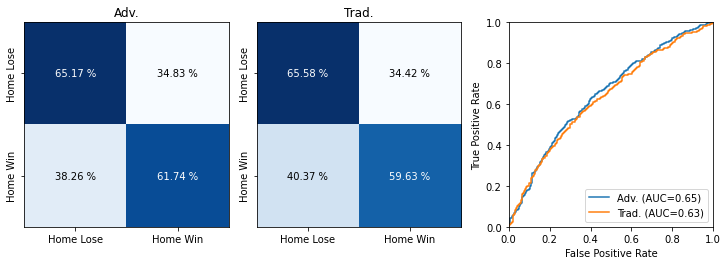

In [ ]:
fig = run_metrics(
    [y_pred_1, y_pred_3], 
    [y_true_1, y_true_3], 
    [y_scores_1[1], y_scores_3[1]]
)
fig.savefig(os.path.join(os.getcwd(), 'drive', 'My Drive', 'teams-NN.pdf'), bbox_inches='tight')

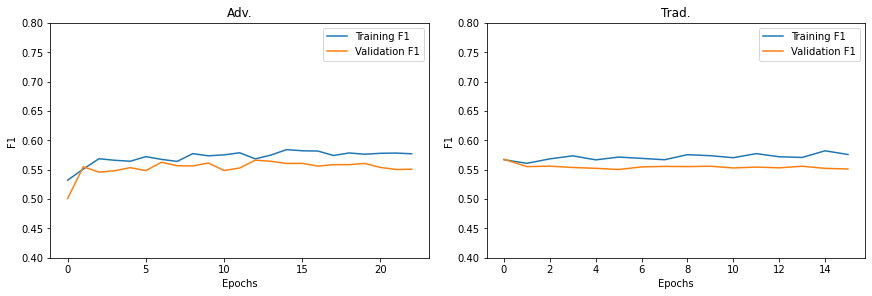

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

ax[0].plot(ann1_hist.history['f1'])
ax[0].plot(ann1_hist.history['val_f1'])
ax[0].legend(['Training F1', 'Validation F1'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('F1')
ax[0].set_ylim((0.4, 0.8))
ax[0].set_title('Adv.')

ax[1].plot(ann3_hist.history['f1'])
ax[1].plot(ann3_hist.history['val_f1'])
ax[1].legend(['Training F1', 'Validation F1'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('F1')
ax[1].set_ylim((0.4, 0.8))
ax[1].set_title('Trad.')

fig.savefig(os.path.join(os.getcwd(), 'drive', 'My Drive','team-NN-curves.pdf'), bbox_inches='tight')

In [25]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


def build_fn(input_dim):
    model = keras.models.Sequential([   
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.BatchNormalization(),    
    
        keras.layers.Dense(8, activation='selu'),
        keras.layers.BatchNormalization(),
    
        keras.layers.Dense(4, activation='selu'),
        keras.layers.BatchNormalization(),
    
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=METRICS)
    return model

ann_clf1 = KerasClassifier(build_fn=build_fn, epochs=30, verbose=0, input_dim=25)
ann_clf2 = KerasClassifier(build_fn=build_fn, epochs=30, verbose=0, input_dim=18)

# prep data for t test
clf_1_X = test_data_1.copy()
clf_1_y = clf_1_X['WON'].values
clf_1_X = clf_1_X.drop([*NON_FEATURE_COLS, 'WON'], axis=1).values

clf_3_X = test_data_3.copy()
clf_3_X = clf_3_X.drop([*NON_FEATURE_COLS, 'WON'], axis=1).values

t, p = ttest(ann_clf1, ann_clf2, clf_1_X, clf_3_X, clf_1_y)
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
t statistic: -1.394
p value: 0.222
